In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
from pyiga import adaptive as adap
#from patchmesh import *
#from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ratio(kv,u,s=0):
    u=(1-u)*kv.support()[0]+u*kv.support()[1]
    if s==0:
        return np.clip(1-(kv.mesh[1:]-u)/(kv.mesh[1:]-kv.mesh[:-1]),a_min=0.,a_max=1.)
    else:
        return np.clip((kv.mesh[1:]-u)/(kv.mesh[1:]-kv.mesh[:-1]),a_min=0.,a_max=1.)

In [3]:
np.outer(ratio(kvs[0],0.25,s=1),ratio(kvs[0],0.25,s=1))

NameError: name 'kvs' is not defined

In [45]:
kvs=2*(bspline.make_knots(2,0,1,3),)
geo=geometry.unit_square()
patches=[(kvs,geo)]
M=topology.PatchMesh(patches)

In [46]:
MP=assemble.Multipatch(M,automatch=True)

In [51]:
MP.patch_refine()

In [52]:
MP.numdofs

1089

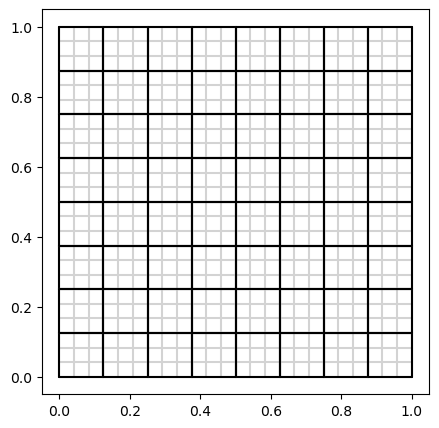

In [53]:
MP.mesh.draw()

In [18]:
assemble.assemble('f * v * dx', kvs, geo=geo, f=f)

array([[0.027, 0.015, 0.063, 0.09 ],
       [0.015, 0.007, 0.027, 0.036],
       [0.063, 0.027, 0.099, 0.126],
       [0.09 , 0.036, 0.126, 0.153]])

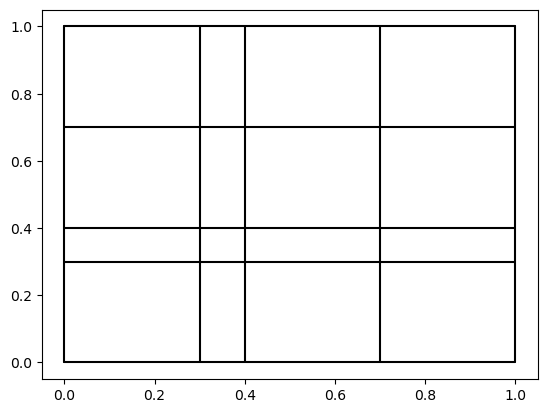

In [20]:
vis.plot_geo(geo,grid=kvs[0].mesh)

In [11]:
bspline.tp_findspan(kvs,(0.5,0.5))

(2, 2)

In [32]:
kvs[0].mesh[:i+2]

array([0. , 0.3, 0.4, 0.7])

In [34]:
kvs[0].mesh[i:]

array([0.4, 0.7, 1. ])

In [19]:
deg, N = 5,10
kvs = 9*[2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]

geos=[
    geometry.unit_square(support=((0.0,1/3),(0.0,1/3))),
    geometry.unit_square(support=((1/3,2/3),(0.0,1/3))),
    geometry.unit_square(support=((2/3,1.0),(0.0,1/3))),
    geometry.unit_square(support=((0.0,1/3),(1/3,2/3))),
    geometry.unit_square(support=((1/3,2/3),(1/3,2/3))),
    geometry.unit_square(support=((2/3,1.0),(1/3,2/3))),
    geometry.unit_square(support=((0.0,1/3),(2/3,1.0))),
    geometry.unit_square(support=((1/3,2/3),(2/3,1.0))),
    geometry.unit_square(support=((2/3,1.0),(2/3,1.0)))
]
patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
#patches = [(k, g) for k, g in zip(kvs,geos)]

# interfaces=[
#     ((0,0,0),(1,1,1),False),
#     ((0,2,0),(2,3,0),False),
#     ((0,1,0),(3,0,0),False),
#     ((0,3,0),(4,2,1),False),
#     ((1,1,0),(2,0,0),False),
#     ((2,3,1),(3,2,0),False),
#     ((3,0,1),(4,1,0),False),
#     ((4,2,0),(1,3,0),False)
# ]
# geos=[geometry.unit_square()]
# patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]

# for g in geos:
#     vis.plot_geo(g,grid=2)
M = topology.PatchMesh(patches, domains={0:{0,1,2,3,5,6,7,8},1:{4}})
M.set_boundary_id({'N':{(0,0),(3,0),(6,0)}})
M.rename_boundary(0,'D')
#M=topology.PatchMesh(patches)

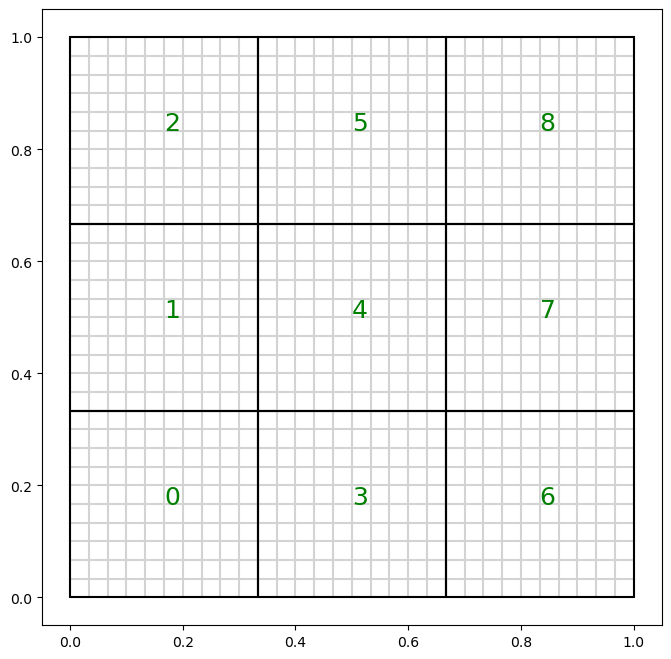

In [20]:
M.draw(patch_idx=True)

In [21]:
M.outer_boundaries

{'N': {(0, 0), (3, 0), (6, 0)},
 'D': {(0, 2), (1, 2), (2, 1), (2, 2), (5, 1), (6, 3), (7, 3), (8, 1), (8, 3)}}

In [22]:
MP = assemble.Multipatch(M, automatch = True)
bcs = MP.compute_dirichlet_bcs({'D':lambda x,y: 100.*y})
Kh = MP.assemble_volume(vform.stiffness_vf(2,a=1), domain_id=0) + MP.assemble_volume(vform.stiffness_vf(2,a=1e6), domain_id=1)
F =  MP.assemble_volume(vform.L2functional_vf(2, physical=False),f=lambda x,y:0.,domain_id=0) + MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=lambda x,y:-10000.,domain_id=1)
LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
#solve system and L2 project exact solution into discrete space
uh=LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

/tmp/ipykernel_7799/766432769.py:7: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh=(cholesky(LS.A))(LS.b)


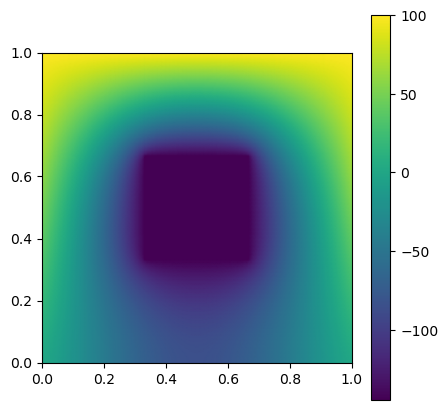

In [23]:
MP.plot(uh)

In [24]:
adap.PoissonEstimator(MP,uh,f={0:lambda x,y: 0.0,1:lambda x,y:-10000.},a={0:1,1:1e6},neu_data={})

array([14.29431, 28.46949, 24.47828, 20.3556 , 46.85329, 34.67759, 14.29431, 28.46949, 24.47828])

In [25]:
adap.PoissonEstimator(MP,uh,f={0:lambda x,y: 0.0,1:lambda x,y:-10000.},a={0:1,1:1e6},neu_data={'N':0.0})

array([14.31745, 28.46949, 24.47828, 20.35564, 46.85329, 34.67759, 14.31745, 28.46949, 24.47828])

In [15]:
def adaptive(M, f, a, u, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    #params['u_sol']=u_sol
    #params['ux']=ux
    #params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(figsize=(6,6))
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
    
        bcs = MP.compute_dirichlet_bcs({0:0})
        #print(bcs)

        # assemble the linear system
        for i, d in enumerate(a):
            if i==0:
                Kh = MP.assemble_volume(vform.stiffness_vf(2,a=a[d]),domain_id=d)
            else:
                Kh += MP.assemble_volume(vform.stiffness_vf(2,a=a[d]),domain_id=d)
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f)
        #Mh, u_rhs = MP.assemble_system(vform.mass_vf(2), vform.L2functional_vf(2, physical=True), f=u)

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        spy(LS.A, markersize=1)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))
        if draw:
            MP.plot(uh)
        #u_ = (cholesky(Mh))(u_rhs)
        #print(check_coupling(MP,u_))
        
        #eh=uh-u_
        #L2err[iter] = eh.T@Mh@eh
        #H1err[iter] = eh.T@Kh@eh + L2err[iter]
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_ind = adap.PoissonEstimator(MP,f,uh,a=a)
            err_est[iter] = np.linalg.norm(err_ind)
            marked_patches = adap.doerfler_marking(err_ind, theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            #print(MP.numdofs)
            start = time.time()
            M.split_patches(patches=marked_patches)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            start=time.time()
            MP = assemble.Multipatch(M, automatch = True)
            end = time.time()
            print("")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return uh, numdofs, np.sqrt(L2err), np.sqrt(H1err), err_est


0


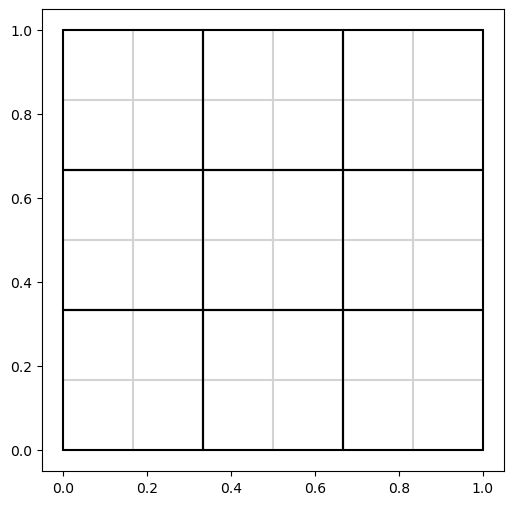

/tmp/ipykernel_2792/44307525.py:42: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


CholmodNotPositiveDefiniteError: ../Cholesky/t_cholmod_rowfac.c:430: not positive definite (code 1)

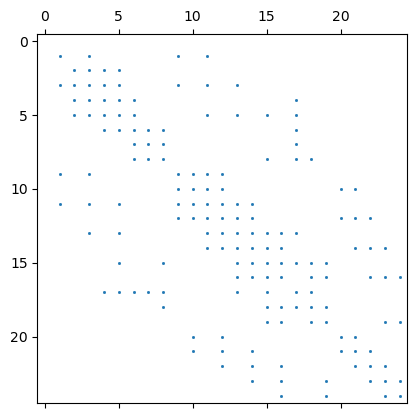

In [16]:
u_,_,_,_,_ = adaptive(M, f=lambda x,y:np.sin(2*pi*x)*np.cos(2*pi*y),u= lambda x,y: 1. ,a={0:1,1:100}, draw=True, maxiter=10)

In [ ]:
MP.plot(u_)

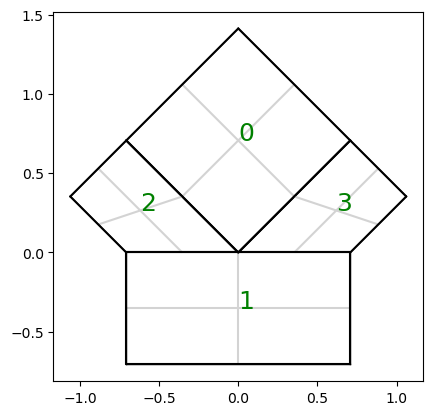

In [5]:
deg, N = 1,2
kvs = 4*[2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]

g1=geometry.unit_square(support=((0.0,1.0),(0.0,0.5))).rotate_2d(pi/4)
g1=g1.scale(1/2).translate((-1/sqrt(2),0))
g1.coeffs[0,1]=np.array([1/sqrt(2),0])
g1.coeffs[1,1]=np.array([-1/sqrt(2)+1/sqrt(2)/2,1/sqrt(2)+1/sqrt(2)/2])

g2=geometry.unit_square(support=((0.0,1.0),(0.5,1.0))).rotate_2d(-pi/4)
g2=g2.scale(1/2).translate((1/sqrt(2)/2,1/sqrt(2)/2))
g2.coeffs[0,0]=np.array([-1/sqrt(2),0])
g2.coeffs[1,0]=np.array([1/sqrt(2)-1/sqrt(2)/2,1/sqrt(2)+1/sqrt(2)/2])
geos=[
    geometry.unit_square().rotate_2d(pi/4),
    geometry.unit_square().scale((np.sqrt(2),1/np.sqrt(2))).translate((-1/sqrt(2),-1/sqrt(2))),
    g1,
    g2
]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]

conn, interfaces = assemble.detect_interfaces(patches)
for i in range(len(interfaces)):
    (p1, bdspec1, p2, bdspec2, conn_info) = interfaces[i]
    interfaces[i] = ((p1, topology.bdspec_to_int(bdspec1), 0), (p2, topology.bdspec_to_int(bdspec2), 0), conn_info[1][0])

interfaces = interfaces + [
    ((1,1,0),(2,0,0),False),
    ((1,1,1),(3,0,0),False)
]

M = topology.PatchMesh(patches, interfaces)
M.draw(patch_idx=True, knots=True)

In [6]:
MP=assemble.Multipatch(M, automatch=True)

setting up constraints took 0.03475308418273926 seconds.
Basis setup took 0.1266951560974121 seconds


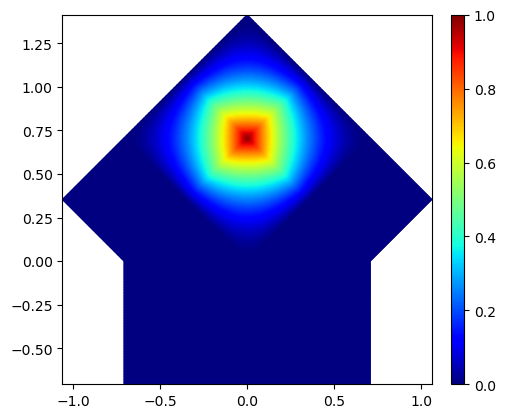

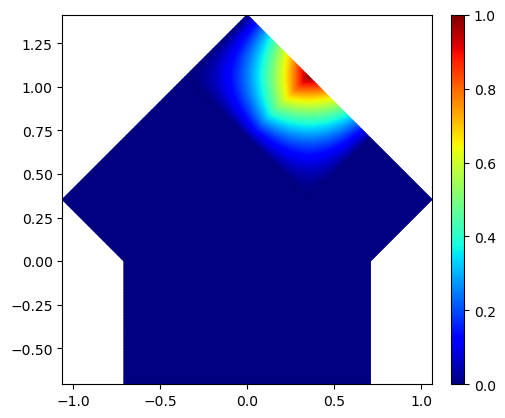

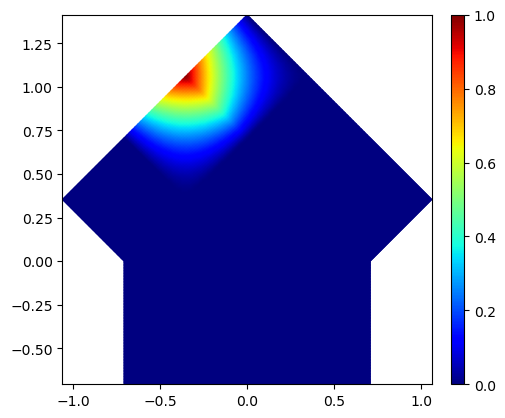

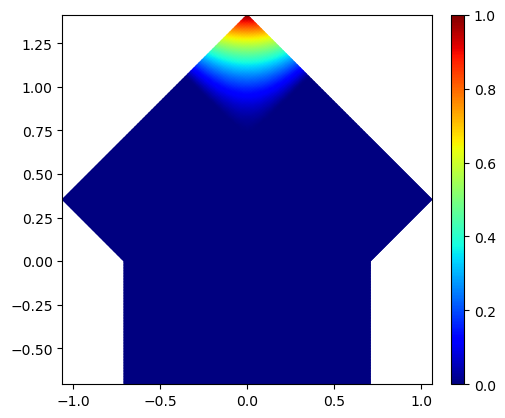

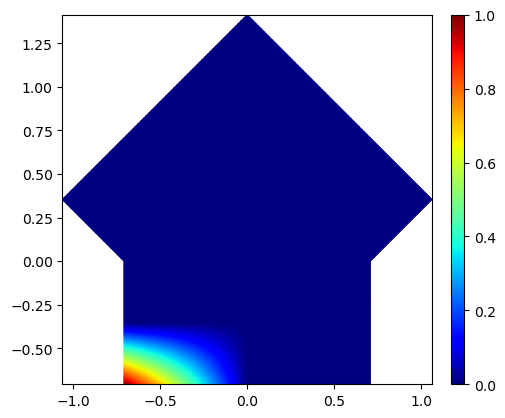

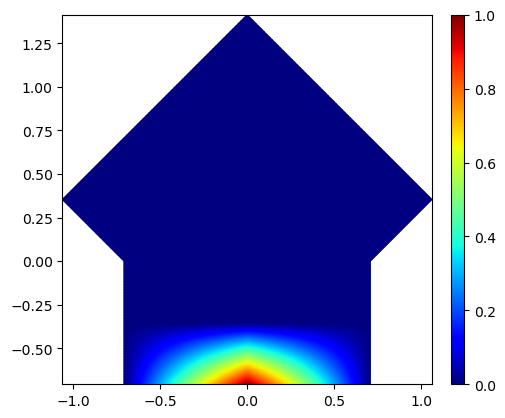

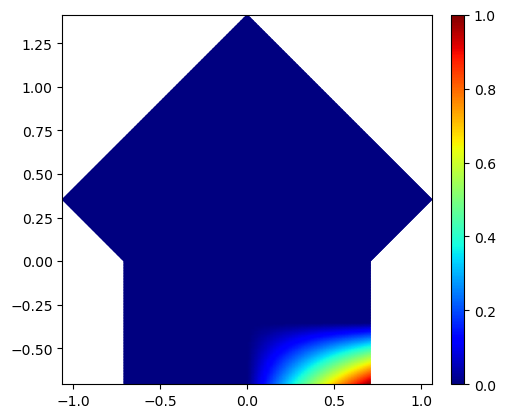

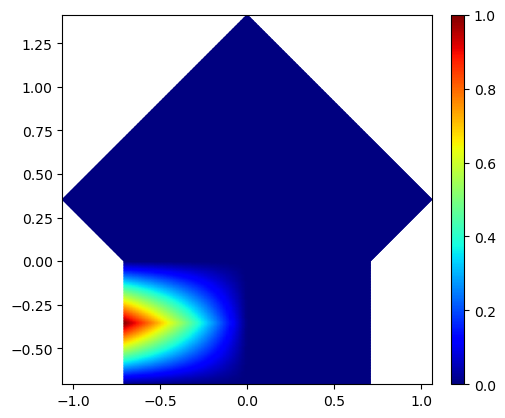

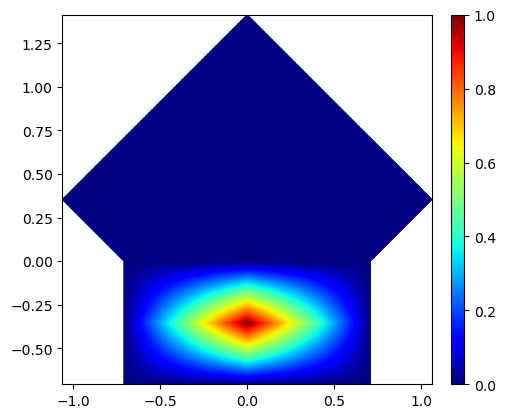

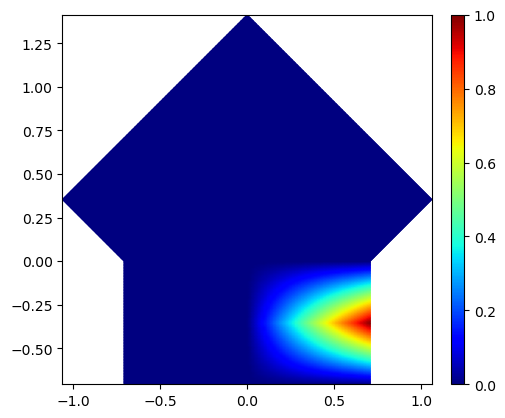

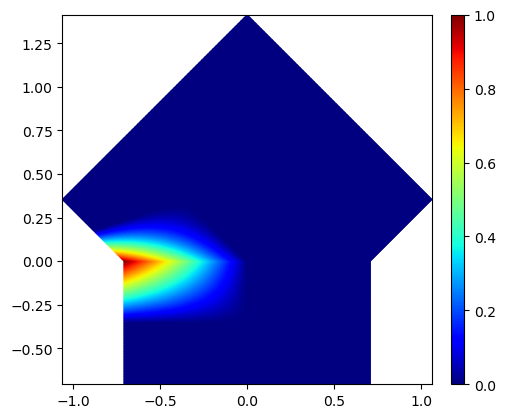

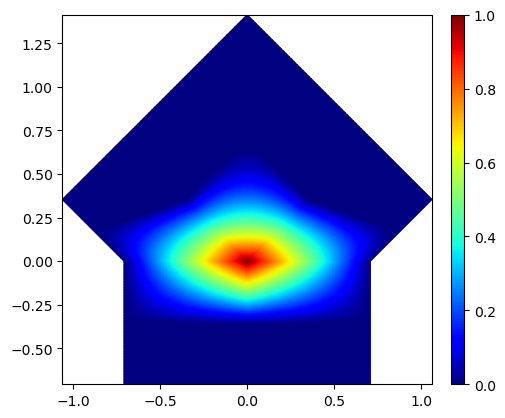

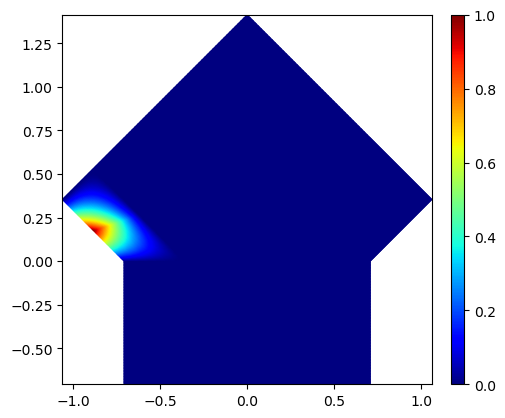

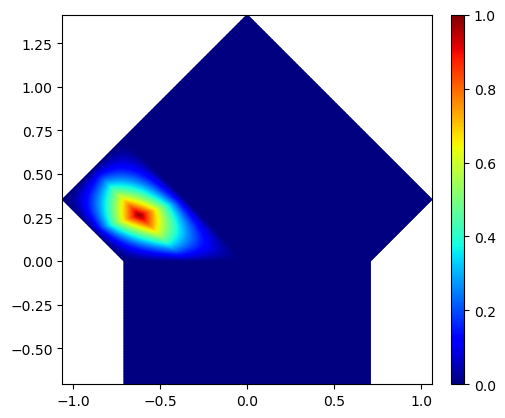

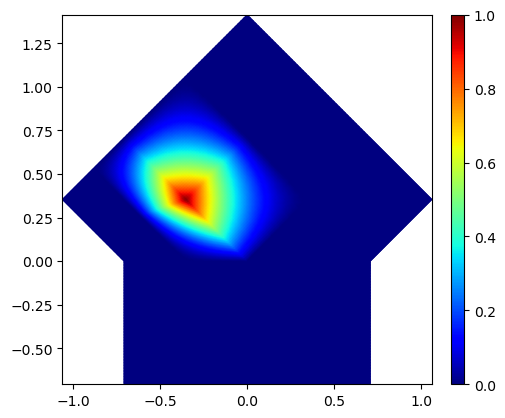

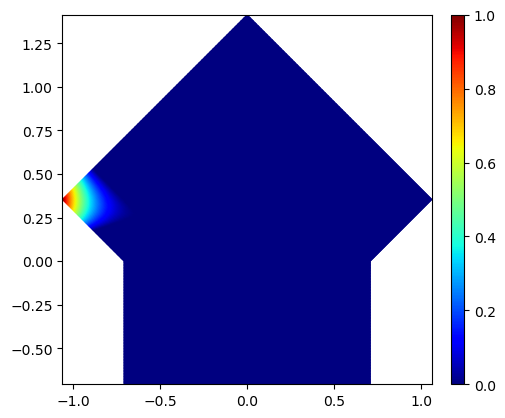

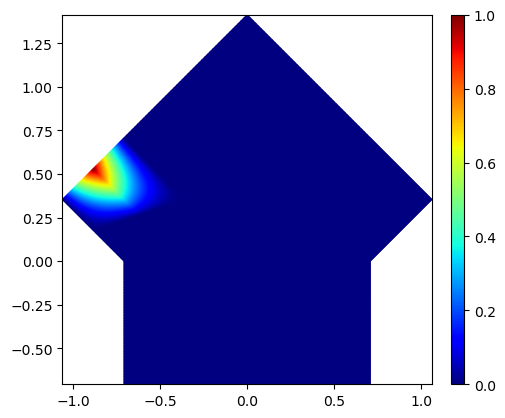

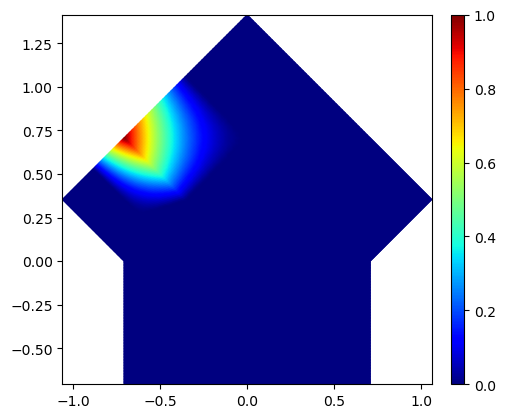

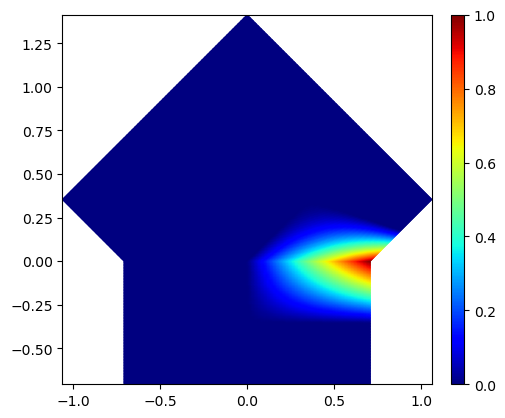

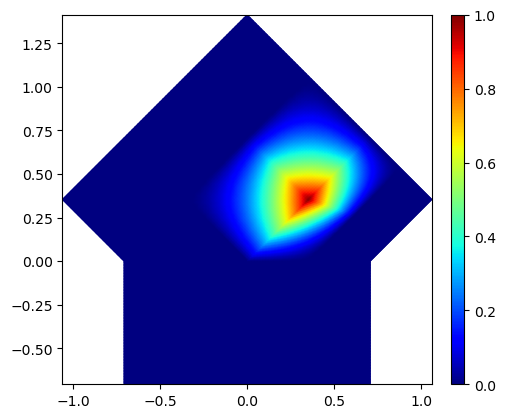

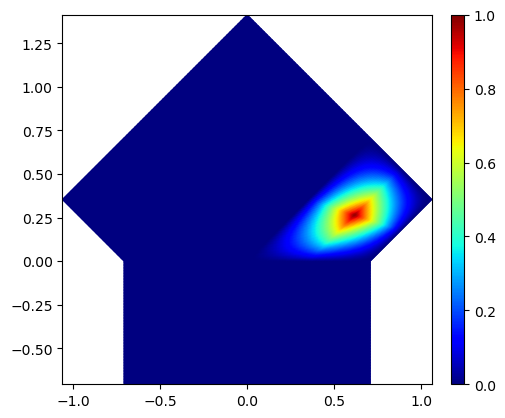

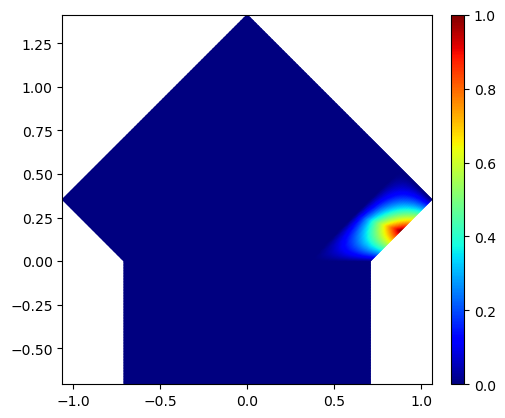

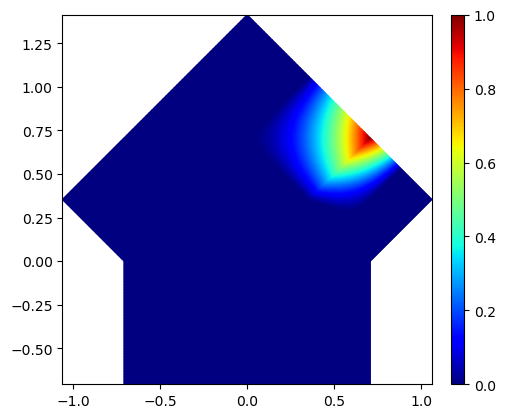

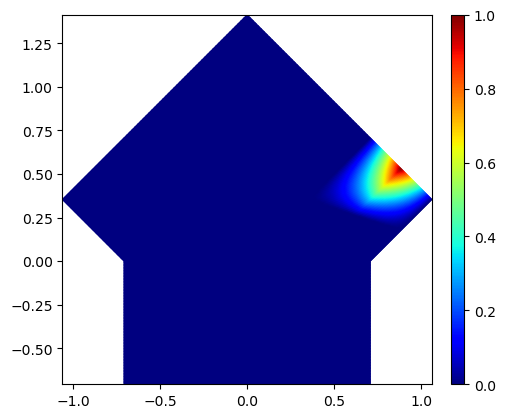

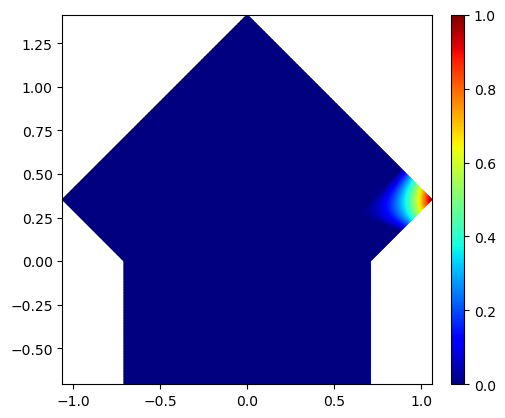

In [7]:
for i in range(MP.numdofs):
    MP.plot(np.eye(1,MP.numdofs,i).ravel())

In [24]:
MP.Basis.A@np.eye(1,MP.numdofs,6).ravel()

array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0.5, 0. , 0. , 0.5, 1. , 0. , 0. ])

In [57]:
deg, N = 1,2
kvs = 3*[2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]
geos=[
    geometry.unit_square(support=((0.0,0.5),(0.0,1.0))),
    geometry.unit_square(support=((0.5,1.0),(0.0,0.5))),
    geometry.unit_square(support=((0.5,1.0),(0.5,1.0)))
]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]

interfaces = [
    ((0,1,0),(2,0,0),False),
    ((0,1,1),(1,0,0),False)
]

M = topology.PatchMesh(patches, interfaces)
#M.draw(patch_idx=True, knots=True)
MP = assemble.Multipatch(M,automatch=True)

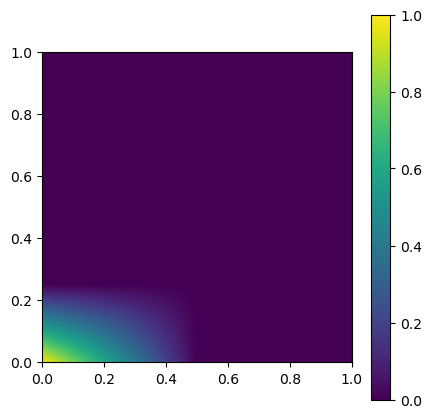

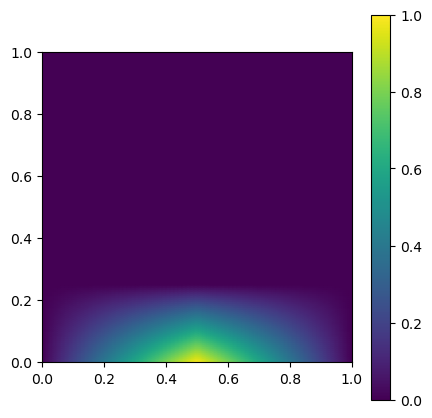

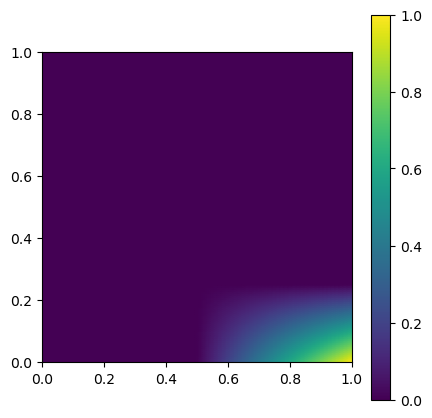

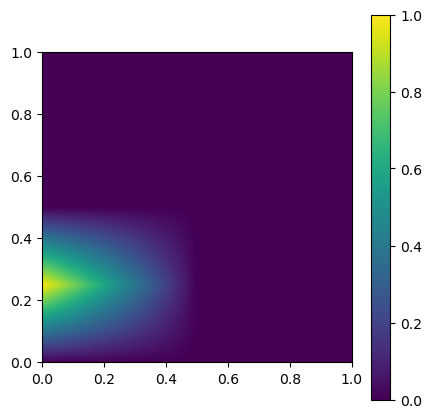

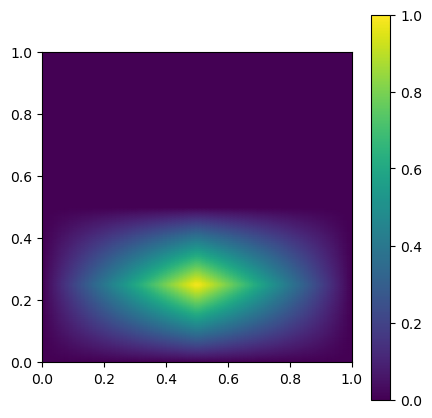

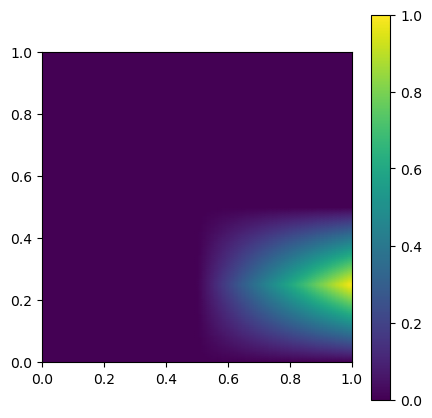

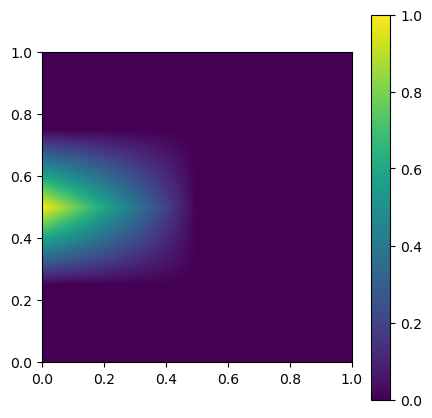

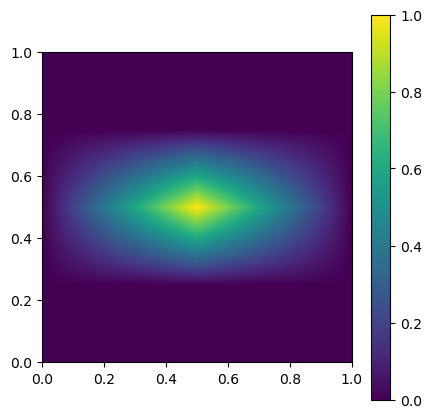

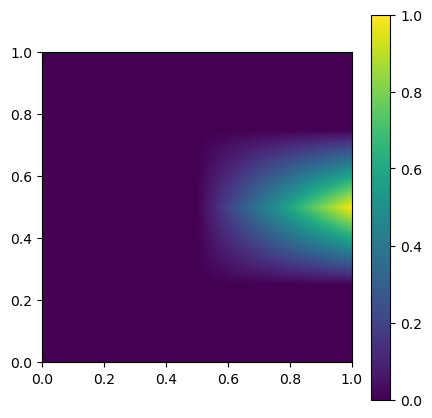

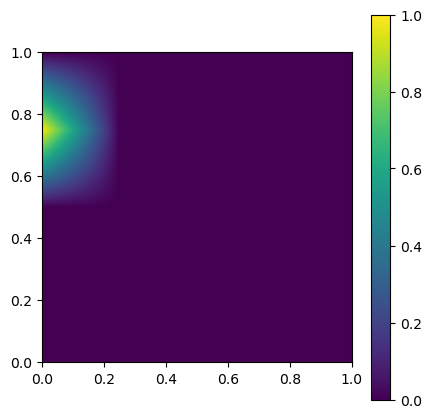

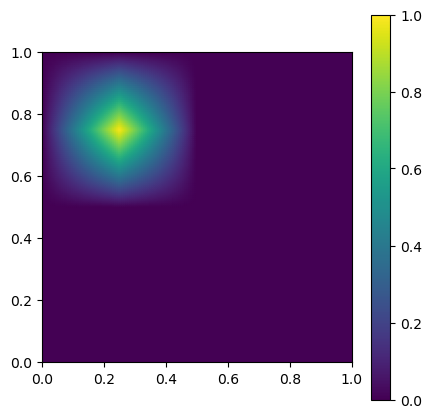

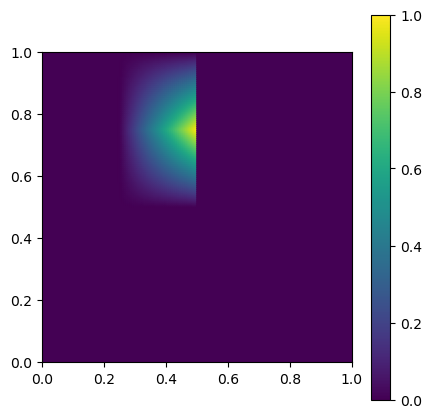

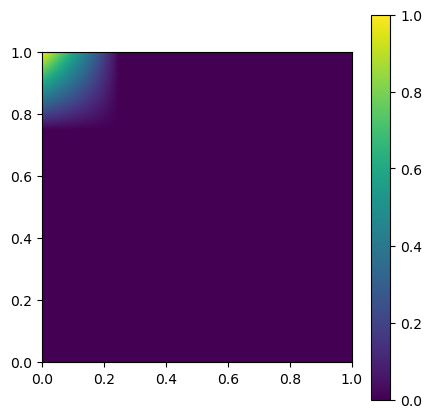

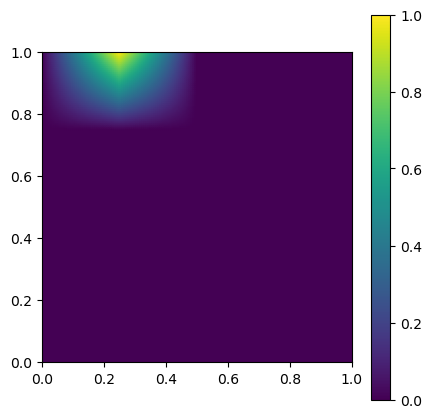

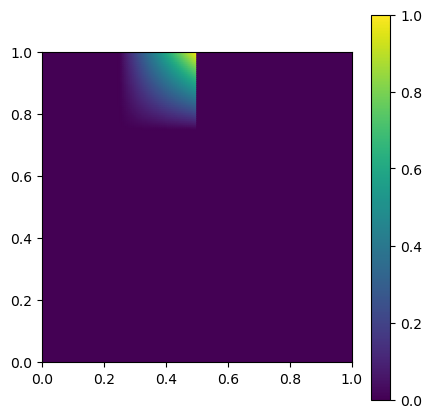

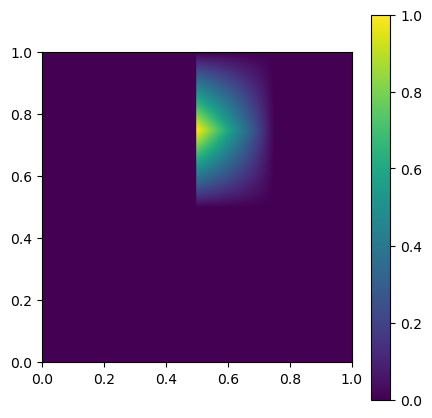

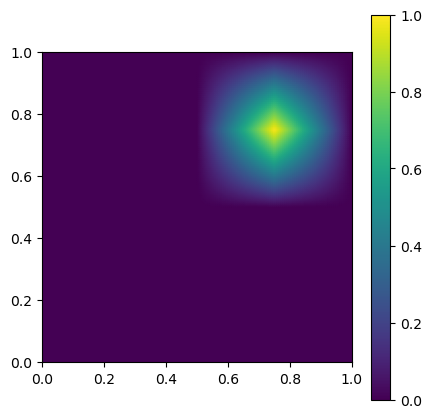

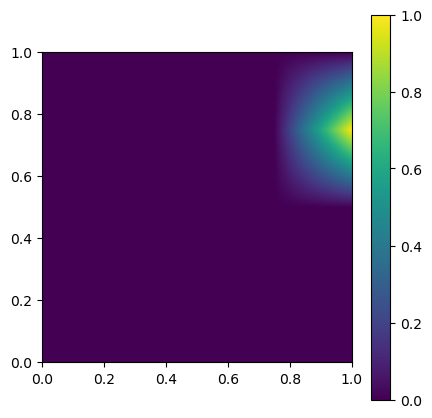

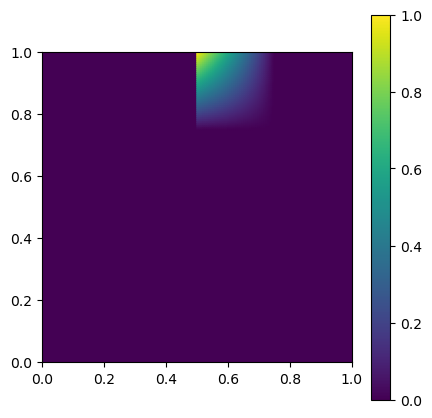

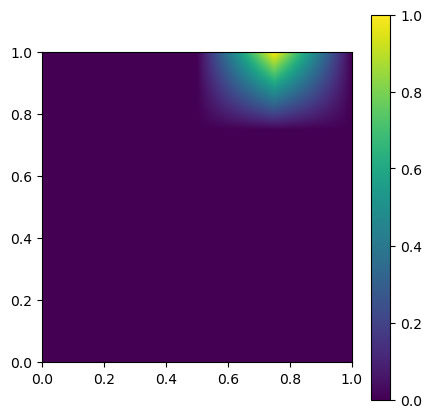

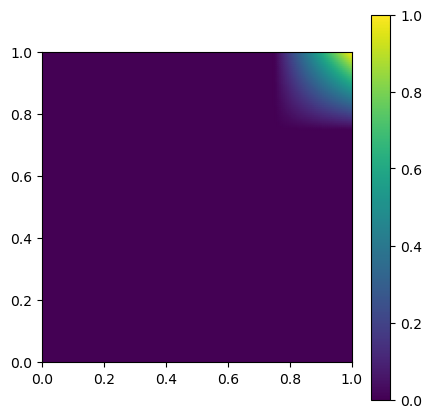

In [58]:
for i in range(MP.numdofs):
    MP.plot(np.eye(1,MP.numdofs,i).ravel())

In [22]:
a=2

In [23]:
(isinstance(a, tuple)) and len(a)==2

False

In [19]:
len({0:1,1:2})

2